In [2]:
# ------------------------------------------------------------------------------ #
# @Author:        F. Paul Spitzner
# @Email:         paul.spitzner@ds.mpg.de
# @Created:       2023-10-09 16:49:35
# @Last Modified: 2023-10-09 16:49:42
# ------------------------------------------------------------------------------ #

%reload_ext autoreload
%autoreload 2
%reload_ext ipy_dict_hierarchy
%reload_ext watermark

import logging
logging.basicConfig(
    format="%(asctime)s | %(levelname)-8s | %(name)-s | %(funcName)-s | %(message)s",
    level=logging.WARNING,
)
log = logging.getLogger("notebook")
log.setLevel("DEBUG")

import re
import glob
import h5py
import sys
import os
import numpy as np
import xarray as xr
import pandas as pd
import dask

from tqdm import tqdm


# also needs to be added for each dask-worker
extra_path = os.path.abspath('../')
sys.path.append(extra_path)
log.info(f"project directory: {extra_path}")

from ana import utility as utl
from ana import plot_helper as ph

ph.log.setLevel("DEBUG")
utl.log.setLevel("DEBUG")

data_dir = "/data.nst/lucas/projects/mouse_visual_timescales_predictability/paper_code/experiment_analysis/data"

2024-05-21 14:58:55,031 | INFO     | notebook | <module> | project directory: /data.nst/lucas/projects/mouse_visual_timescales_predictability/paper_code_repo/experiment_analysis


In [3]:
# load our results from timescale fitting
meta_df = pd.read_hdf(f"{data_dir}/all_units_merged_blocks_with_spont.h5", key="meta_df")

# add metrics from image selectivity etc.
meta_df = utl.load_metrics(meta_df.reset_index(), data_dir)
meta_df

2024-05-21 14:59:06,675 | DEBUG    | its_utility | load_metrics | Loaded columns ['unit_id', 'g_dsi_dg', 'mod_idx_dg', 'on_screen_rf', 'image_selectivity_ns'] from /data.nst/lucas/projects/mouse_visual_timescales_predictability/paper_code/experiment_analysis/data/brain_observatory_unit_metrics_filtered.csv
2024-05-21 14:59:06,678 | DEBUG    | its_utility | load_metrics | Matched 6368 rows from meta_df in /data.nst/lucas/projects/mouse_visual_timescales_predictability/paper_code/experiment_analysis/data/brain_observatory_unit_metrics_filtered.csv


,unit_id,stimulus,session,block,ecephys_structure_acronym,invalid_spiketimes_check,recording_length,firing_rate,filepath,num_spikes,...,tau_R,tau_single,tau_double,tau_R_details,tau_single_details,tau_double_details,g_dsi_dg,image_selectivity_ns,mod_idx_dg,on_screen_rf
0,950911932,natural_movie_three,715093703,merged_3.0_and_6.0,VISam,SUCCESS,1078.491211,8.025100,/project.nst/neuroscience-raw/Allen/visual_cod...,8655,...,0.058510,0.000054,0.748946,"{'firing_rate': 8.012090922999178, 'firing_rat...","{'tau': 5.404084198337884e-05, 'mre': 6.575654...","{'tau': 0.7489462162647652, 'mre': 0.993346188...",0.095447,0.164169,1.353636,False
1,950911986,natural_movie_three,715093703,merged_3.0_and_6.0,VISam,SUCCESS,1079.203369,3.647135,/project.nst/neuroscience-raw/Allen/visual_cod...,3936,...,0.088701,2.302634,1.874703,"{'firing_rate': 3.6471291367256455, 'firing_ra...","{'tau': 2.3026338728859774, 'mre': 0.997830929...","{'tau': 1.874703126979266, 'mre': 0.9973364645...",0.108358,0.017271,0.639408,False
2,950912164,natural_movie_three,715093703,merged_3.0_and_6.0,VISam,SUCCESS,1077.872803,8.500075,/project.nst/neuroscience-raw/Allen/visual_cod...,9162,...,0.059416,1.026283,1.026284,"{'firing_rate': 8.475008697669026, 'firing_rat...","{'tau': 1.0262833654998276, 'mre': 0.995139899...","{'tau': 1.0262836602024297, 'mre': 0.995139901...",0.228699,0.598220,1.030492,True
3,950912190,natural_movie_three,715093703,merged_3.0_and_6.0,VISam,SUCCESS,1075.171875,4.399297,/project.nst/neuroscience-raw/Allen/visual_cod...,4730,...,0.116100,1.564297,1.363502,"{'firing_rate': 4.395563512916502, 'firing_rat...","{'tau': 1.5642971952849982, 'mre': 0.996808779...","{'tau': 1.363502294341311, 'mre': 0.9963396881...",0.056741,0.348424,0.999923,True
4,950912214,natural_movie_three,715093703,merged_3.0_and_6.0,VISam,SUCCESS,1073.492432,5.326540,/project.nst/neuroscience-raw/Allen/visual_cod...,5718,...,0.064748,0.605686,0.377801,"{'firing_rate': 5.317211538013684, 'firing_rat...","{'tau': 0.6056864214354767, 'mre': 0.991778883...","{'tau': 0.37780093267583975, 'mre': 0.98685270...",0.069080,0.422288,0.219870,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17944,950942400,spontaneous,771160300,null,VISal,SUCCESS,1797.115234,0.377828,/project.nst/neuroscience-raw/Allen/visual_cod...,679,...,0.049446,0.257024,0.217925,"{'firing_rate': 0.36583331347267567, 'firing_r...","{'tau': 0.25702383931940154, 'mre': 0.98073454...","{'tau': 0.2179251442600049, 'mre': 0.977317546...",NaN,NaN,NaN,NaN
17945,950944614,spontaneous,771160300,null,VISal,SUCCESS,1792.901855,0.377600,/project.nst/neuroscience-raw/Allen/visual_cod...,677,...,0.042486,0.439570,0.057439,"{'firing_rate': 0.38629086027452963, 'firing_r...","{'tau': 0.4395698459887982, 'mre': 0.988689691...","{'tau': 0.05743850656844875, 'mre': 0.91663161...",NaN,NaN,NaN,NaN
17946,950943984,spontaneous,771160300,null,VISal,SUCCESS,1773.977051,0.135289,/project.nst/neuroscience-raw/Allen/visual_cod...,240,...,0.043392,0.170987,0.170986,"{'firing_rate': 0.13628681470096451, 'firing_r...","{'tau': 0.1709865057191234, 'mre': 0.971181338...","{'tau': 0.17098641292634262, 'mre': 0.97118132...",NaN,NaN,NaN,NaN
17947,950942680,spontaneous,771160300,null,VISal,SUCCESS,1801.591797,12.195324,/project.nst/neuroscience-raw/Allen/visual_cod...,21971,...,0.008184,0.081918,0.068260,"{'firing_rate': 12.154834329411557, 'firing_ra...","{'tau': 0.08191797577480081, 'mre': 0.94078874...","{'tau': 0.06826005692776223, 'mre': 0.92936912...",NaN,NaN,NaN,NaN


In [4]:
# TODO: make these default preprocessing steps.

# sanity check, selectivity should be present for all units in natural_movie_three
assert (
    len(meta_df.query("stimulus == 'natural_movie_three'"))
    == np.isfinite(meta_df.query("stimulus == 'natural_movie_three'")["mod_idx_dg"]).sum()
)

# exclude nans for now ~ 5 rows with low rates and one todo for unit 951021415
# TODO: 0.05 firing rate threshold seems better
meta_df = meta_df.query("R_tot == R_tot")
len_before = len(meta_df)
meta_df = meta_df.query("tau_R > 0.0")
meta_df = meta_df.query("tau_double > 0.0 & tau_double < 10.0")
# timescales above 10s are likely an inference problems,
# as we have 600 - 800 seconds of data. cf. https://arxiv.org/abs/2007.03367
len_after = len(meta_df)
log.info(f"removed {len_before - len_after} rows due to unexpected timescales")


2024-05-21 15:00:34,831 | INFO     | notebook | <module> | removed 995 rows due to unexpected timescales


In [5]:
# we need a mapping from ephys acronyms to the names we use in the paper
structure_names = {
    "VISp" : "V1",
    "VISl" : "LM",
    "VISrl" : "RL",
    "VISal" : "AL",
    "VISpm" : "PM",
    "VISam" : "AM",
    "LGd" : "LGN",
    "LP" : "LP",
}

# apply to dataframe
meta_df["structure_name"] = meta_df["ecephys_structure_acronym"].apply(
    lambda x: structure_names[x]
)

# TODO: dump the final, cleaned dataframe to disk again.

meta_df

,unit_id,stimulus,session,block,ecephys_structure_acronym,invalid_spiketimes_check,recording_length,firing_rate,filepath,num_spikes,...,tau_single,tau_double,tau_R_details,tau_single_details,tau_double_details,g_dsi_dg,image_selectivity_ns,mod_idx_dg,on_screen_rf,structure_name
0,950911932,natural_movie_three,715093703,merged_3.0_and_6.0,VISam,SUCCESS,1078.491211,8.025100,/project.nst/neuroscience-raw/Allen/visual_cod...,8655,...,0.000054,0.748946,"{'firing_rate': 8.012090922999178, 'firing_rat...","{'tau': 5.404084198337884e-05, 'mre': 6.575654...","{'tau': 0.7489462162647652, 'mre': 0.993346188...",0.095447,0.164169,1.353636,False,AM
1,950911986,natural_movie_three,715093703,merged_3.0_and_6.0,VISam,SUCCESS,1079.203369,3.647135,/project.nst/neuroscience-raw/Allen/visual_cod...,3936,...,2.302634,1.874703,"{'firing_rate': 3.6471291367256455, 'firing_ra...","{'tau': 2.3026338728859774, 'mre': 0.997830929...","{'tau': 1.874703126979266, 'mre': 0.9973364645...",0.108358,0.017271,0.639408,False,AM
2,950912164,natural_movie_three,715093703,merged_3.0_and_6.0,VISam,SUCCESS,1077.872803,8.500075,/project.nst/neuroscience-raw/Allen/visual_cod...,9162,...,1.026283,1.026284,"{'firing_rate': 8.475008697669026, 'firing_rat...","{'tau': 1.0262833654998276, 'mre': 0.995139899...","{'tau': 1.0262836602024297, 'mre': 0.995139901...",0.228699,0.598220,1.030492,True,AM
3,950912190,natural_movie_three,715093703,merged_3.0_and_6.0,VISam,SUCCESS,1075.171875,4.399297,/project.nst/neuroscience-raw/Allen/visual_cod...,4730,...,1.564297,1.363502,"{'firing_rate': 4.395563512916502, 'firing_rat...","{'tau': 1.5642971952849982, 'mre': 0.996808779...","{'tau': 1.363502294341311, 'mre': 0.9963396881...",0.056741,0.348424,0.999923,True,AM
4,950912214,natural_movie_three,715093703,merged_3.0_and_6.0,VISam,SUCCESS,1073.492432,5.326540,/project.nst/neuroscience-raw/Allen/visual_cod...,5718,...,0.605686,0.377801,"{'firing_rate': 5.317211538013684, 'firing_rat...","{'tau': 0.6056864214354767, 'mre': 0.991778883...","{'tau': 0.37780093267583975, 'mre': 0.98685270...",0.069080,0.422288,0.219870,True,AM
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17944,950942400,spontaneous,771160300,null,VISal,SUCCESS,1797.115234,0.377828,/project.nst/neuroscience-raw/Allen/visual_cod...,679,...,0.257024,0.217925,"{'firing_rate': 0.36583331347267567, 'firing_r...","{'tau': 0.25702383931940154, 'mre': 0.98073454...","{'tau': 0.2179251442600049, 'mre': 0.977317546...",NaN,NaN,NaN,NaN,AL
17945,950944614,spontaneous,771160300,null,VISal,SUCCESS,1792.901855,0.377600,/project.nst/neuroscience-raw/Allen/visual_cod...,677,...,0.439570,0.057439,"{'firing_rate': 0.38629086027452963, 'firing_r...","{'tau': 0.4395698459887982, 'mre': 0.988689691...","{'tau': 0.05743850656844875, 'mre': 0.91663161...",NaN,NaN,NaN,NaN,AL
17946,950943984,spontaneous,771160300,null,VISal,SUCCESS,1773.977051,0.135289,/project.nst/neuroscience-raw/Allen/visual_cod...,240,...,0.170987,0.170986,"{'firing_rate': 0.13628681470096451, 'firing_r...","{'tau': 0.1709865057191234, 'mre': 0.971181338...","{'tau': 0.17098641292634262, 'mre': 0.97118132...",NaN,NaN,NaN,NaN,AL
17947,950942680,spontaneous,771160300,null,VISal,SUCCESS,1801.591797,12.195324,/project.nst/neuroscience-raw/Allen/visual_cod...,21971,...,0.081918,0.068260,"{'firing_rate': 12.154834329411557, 'firing_ra...","{'tau': 0.08191797577480081, 'mre': 0.94078874...","{'tau': 0.06826005692776223, 'mre': 0.92936912...",NaN,NaN,NaN,NaN,AL


In [6]:
print(meta_df["block"].unique())
print(meta_df["stimulus"].unique())

['merged_3.0_and_6.0' 'merged_3.0_and_8.0' 'null']
['natural_movie_three' 'natural_movie_one_more_repeats' 'spontaneous']


2024-05-21 15:01:28,251 | INFO     | plot_helper | panel_areas_grouped | grouped tau_double for ['natural_movie_one_more_repeats'] ['merged_3.0_and_8.0'] with 5312 rows
2024-05-21 15:01:35,908 | INFO     | plot_helper | panel_areas_grouped | grouped tau_R for ['natural_movie_one_more_repeats'] ['merged_3.0_and_8.0'] with 5312 rows
2024-05-21 15:01:44,505 | INFO     | plot_helper | panel_areas_grouped | grouped R_tot for ['natural_movie_one_more_repeats'] ['merged_3.0_and_8.0'] with 5312 rows


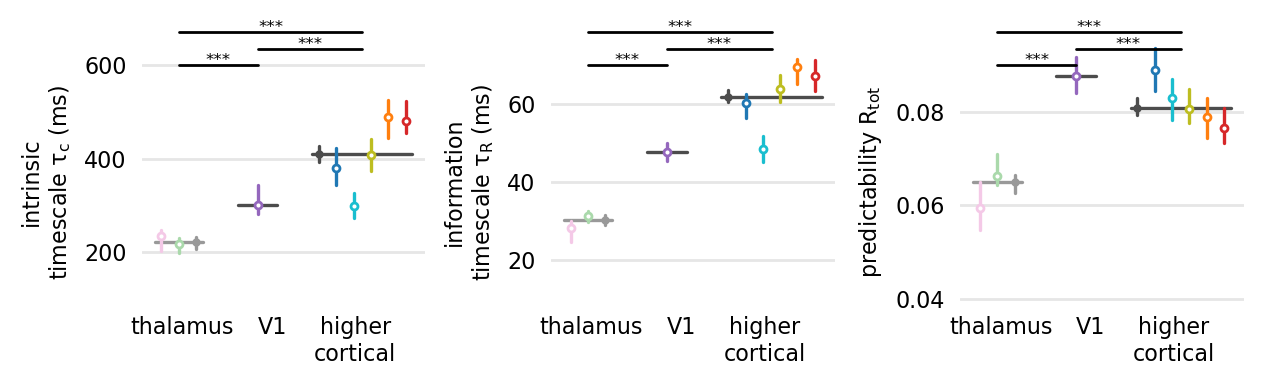

In [7]:
# Pick a block and plot the hierarchy.
# results should be consistent across blocks.

ph.log.setLevel("INFO")  # set to debug for p-values
df = meta_df.query("(stimulus == 'natural_movie_one_more_repeats') & (block == 'merged_3.0_and_8.0')")
ph.row_structure_groups(df);

2024-05-21 13:48:00,211 | INFO     | plot_helper | panel_hierarchy_score | dropping LGN and LP to focus on cortical hierarchy
2024-05-21 13:48:00,216 | INFO     | plot_helper | panel_hierarchy_score | plotting tau_double agains hierarchy score for ['natural_movie_one_more_repeats'] ['merged_3.0_and_8.0'] with 4765 rows
2024-05-21 13:48:02,973 | INFO     | plot_helper | panel_hierarchy_score | dropping LGN and LP to focus on cortical hierarchy
2024-05-21 13:48:02,977 | INFO     | plot_helper | panel_hierarchy_score | plotting tau_R agains hierarchy score for ['natural_movie_one_more_repeats'] ['merged_3.0_and_8.0'] with 4765 rows
2024-05-21 13:48:05,775 | INFO     | plot_helper | panel_hierarchy_score | dropping LGN and LP to focus on cortical hierarchy
2024-05-21 13:48:05,779 | INFO     | plot_helper | panel_hierarchy_score | plotting R_tot agains hierarchy score for ['natural_movie_one_more_repeats'] ['merged_3.0_and_8.0'] with 4765 rows


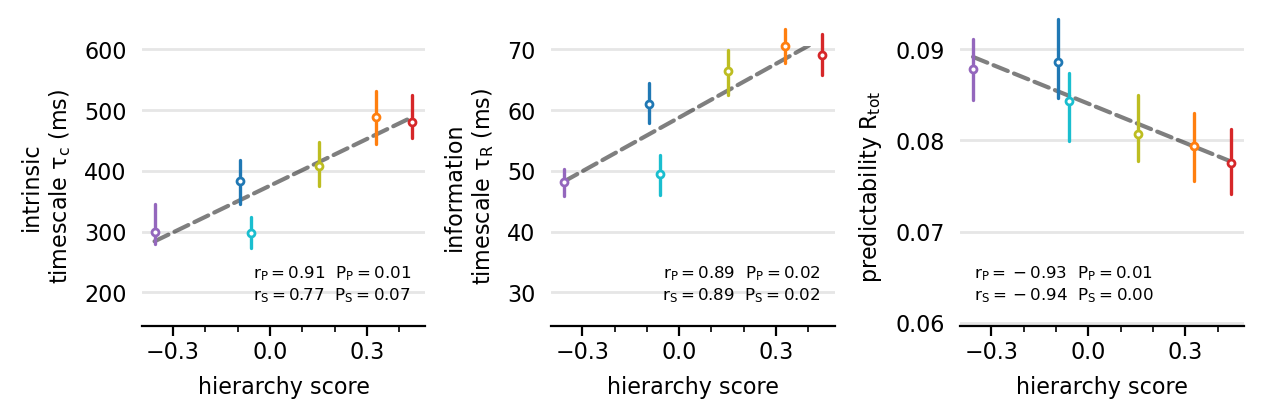

In [7]:
ph.log.setLevel("INFO")
df = meta_df.query("(stimulus == 'natural_movie_one_more_repeats') & (block == 'merged_3.0_and_8.0')")
ph.row_hierarchy_score(df);

2024-05-21 15:02:25,252 | INFO     | plot_helper | panel_areas_grouped | grouped tau_double for ['natural_movie_three'] ['merged_3.0_and_6.0'] with 6076 rows
2024-05-21 15:02:32,768 | INFO     | plot_helper | panel_areas_grouped | grouped tau_R for ['natural_movie_three'] ['merged_3.0_and_6.0'] with 6076 rows
2024-05-21 15:02:40,281 | INFO     | plot_helper | panel_areas_grouped | grouped R_tot for ['natural_movie_three'] ['merged_3.0_and_6.0'] with 6076 rows
2024-05-21 15:02:47,874 | INFO     | plot_helper | panel_hierarchy_score | dropping LGN and LP to focus on cortical hierarchy
2024-05-21 15:02:47,879 | INFO     | plot_helper | panel_hierarchy_score | plotting tau_double agains hierarchy score for ['natural_movie_three'] ['merged_3.0_and_6.0'] with 4758 rows
2024-05-21 15:02:51,466 | INFO     | plot_helper | panel_hierarchy_score | dropping LGN and LP to focus on cortical hierarchy
2024-05-21 15:02:51,472 | INFO     | plot_helper | panel_hierarchy_score | plotting tau_R agains hie

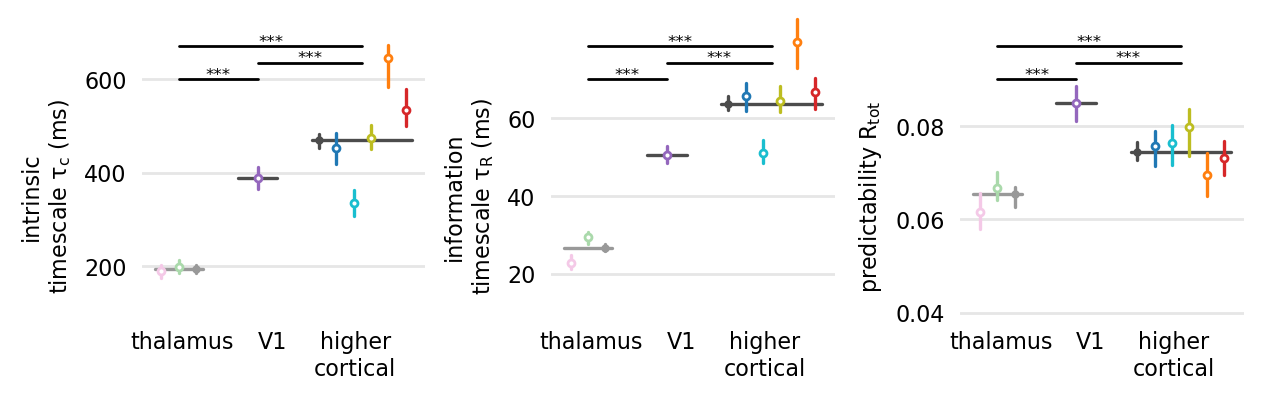

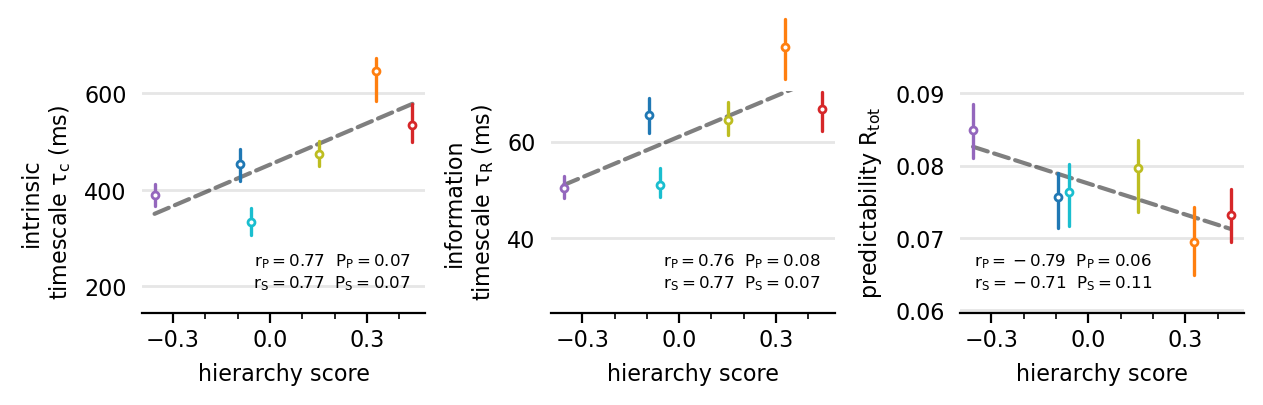

In [8]:
# Plots for Brain observatory (natural movie three)

ph.log.setLevel("INFO")  # set to debug for p-values
df = meta_df.query("(stimulus == 'natural_movie_three') & (block == 'merged_3.0_and_6.0')")
ph.row_structure_groups(df);

ph.log.setLevel("INFO")
df = meta_df.query("(stimulus == 'natural_movie_three') & (block == 'merged_3.0_and_6.0')")
ph.row_hierarchy_score(df);

2024-05-21 13:52:43,252 | INFO     | plot_helper | panel_areas_grouped | grouped tau_double for ['spontaneous'] ['null'] with 5858 rows
2024-05-21 13:52:48,753 | INFO     | plot_helper | panel_areas_grouped | grouped tau_R for ['spontaneous'] ['null'] with 5858 rows
2024-05-21 13:52:54,173 | INFO     | plot_helper | panel_areas_grouped | grouped R_tot for ['spontaneous'] ['null'] with 5858 rows
2024-05-21 13:52:59,862 | INFO     | plot_helper | panel_hierarchy_score | dropping LGN and LP to focus on cortical hierarchy
2024-05-21 13:52:59,867 | INFO     | plot_helper | panel_hierarchy_score | plotting tau_double agains hierarchy score for ['spontaneous'] ['null'] with 5000 rows
2024-05-21 13:53:02,599 | INFO     | plot_helper | panel_hierarchy_score | dropping LGN and LP to focus on cortical hierarchy
2024-05-21 13:53:02,603 | INFO     | plot_helper | panel_hierarchy_score | plotting tau_R agains hierarchy score for ['spontaneous'] ['null'] with 5000 rows
2024-05-21 13:53:05,312 | INFO 

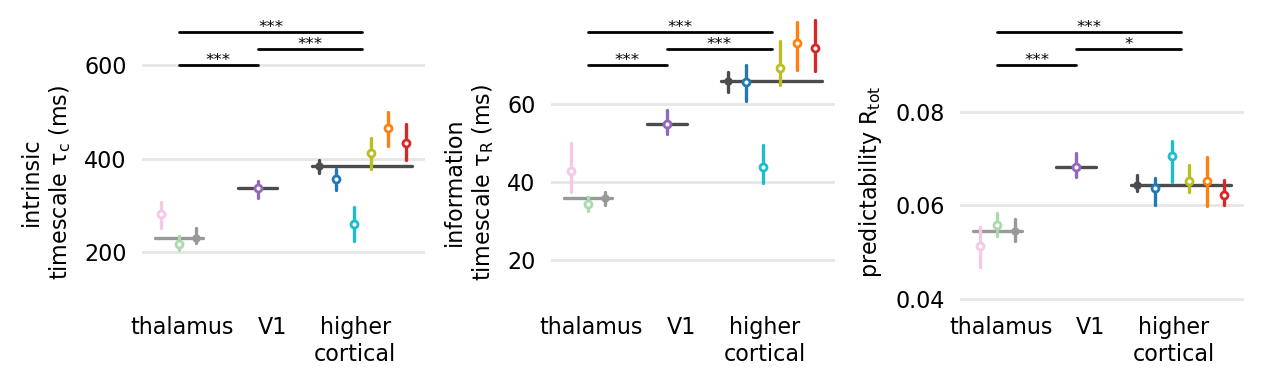

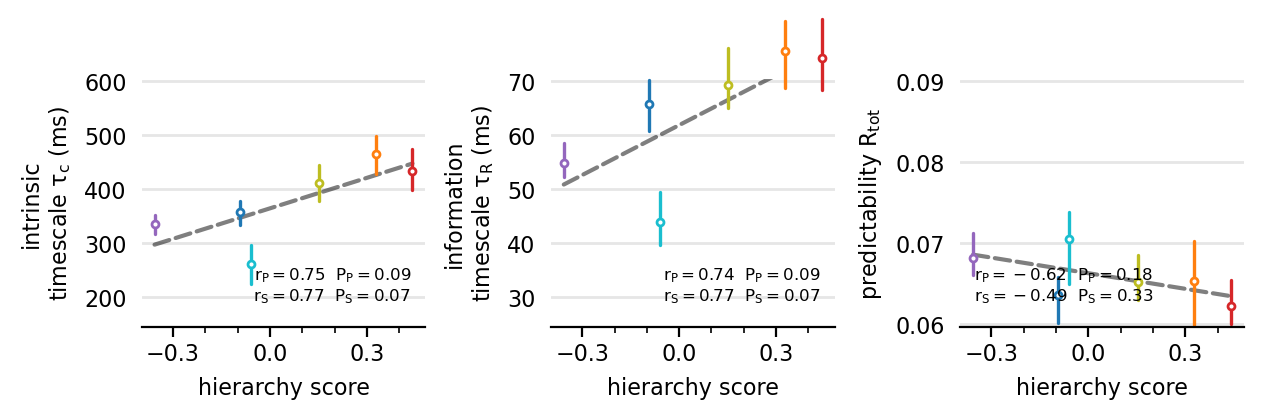

In [10]:
# Plots for Functional connectivity (spontaneous)
# Plots for Brain observatory (natural movie three)

ph.log.setLevel("INFO")  # set to debug for p-values
df = meta_df.query("(stimulus == 'spontaneous') & (block == 'null')")
ph.row_structure_groups(df);

ph.log.setLevel("INFO")
df = meta_df.query("(stimulus == 'spontaneous') & (block == 'null')")
ph.row_hierarchy_score(df);

In [15]:
%watermark -v --iversions --packages scipy

Python implementation: CPython
Python version       : 3.11.4
IPython version      : 8.14.0

scipy: 1.11.1

numpy         : 1.24.4
prompt_toolkit: 3.0.39
re            : 2.2.1
IPython       : 8.14.0
pandas        : 2.0.3
sys           : 3.11.4 | packaged by conda-forge | (main, Jun 10 2023, 18:08:41) [Clang 15.0.7 ]
logging       : 0.5.1.2
h5py          : 3.9.0
sqlite3       : 2.6.0
matplotlib    : 3.7.2
xarray        : 2023.7.0
dask          : 2023.7.1

